Tenx — Task 1: Preprocess & Explore the Data
**Goal:** implement Task 1 from the *Time Series Forecasting for Portfolio Management Optimization* challenge:
fetch historical data for TSLA, BND, SPY (2015-07-01 → 2025-07-31), clean it, run EDA, compute returns & volatility,
detect outliers, test stationarity, and produce risk metrics (VaR, Sharpe).

This notebook follows the challenge instructions step-by-step and saves cleaned CSVs + key plots for the interim submission.

In [ ]:
!pip install --quiet yfinance pandas numpy matplotlib seaborn statsmodels pmdarima scipy scikit-learn

# Standard imports
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from scipy import stats
plt.rcParams['figure.figsize'] = (12,6)
sns.set(style='darkgrid')
print('Packages imported.')

# 1) Fetch data from yfinance

In [2]:

tickers = ['TSLA','BND','SPY']
start = '2015-07-01'
end = '2025-07-31'


raw = yf.download(tickers, start=start, end=end, progress=False, group_by='ticker', auto_adjust=False)


display(raw.head())
raw.info()

Ticker             SPY                                                  \
Price             Open        High         Low       Close   Adj Close   
Date                                                                     
2015-07-01  207.729996  208.029999  206.559998  207.500000  174.917130   
2015-07-02  208.070007  208.270004  206.809998  207.309998  174.756912   
2015-07-06  205.770004  207.649994  205.529999  206.720001  174.259583   
2015-07-07  206.960007  208.169998  204.110001  208.020004  175.355469   
2015-07-08  206.419998  206.759995  204.250000  204.529999  172.413452   

Ticker                       BND                                              \
Price          Volume       Open       High        Low      Close  Adj Close   
Date                                                                           
2015-07-01  135979900  80.870003  81.029999  80.830002  80.900002  60.816750   
2015-07-02  104373700  81.059998  81.180000  81.059998  81.099998  60.967110   
2015-07-06  117975400  81.440002  81.440002  81.220001  81.379997  61.177567   
2015-07-07  173820200  81.690002  81.769997  81.459999  81.459999  61.237732   
2015-07-08  164020100  81.639999  81.760002  81.559998  81.690002  61.410606   

Ticker                    TSLA                                              \
Price        Volume       Open       High        Low      Close  Adj Close   
Date                                                                         
2015-07-01  5399300  18.073999  18.174667  17.856667  17.943333  17.943333   
2015-07-02  1060100  18.680000  18.830000  18.220667  18.667999  18.667999   
2015-07-06  2210700  18.591999  18.779333  18.420000  18.648001  18.648001   
2015-07-07  4183200  18.333332  18.346666  17.384666  17.858667  17.858667   
2015-07-08  1967800  17.288000  17.386667  16.954000  16.997334  16.997334   

Ticker                 
Price          Volume  
Date                   
2015-07-01   31518000  
2015-07-02  107458500  
2015-07-06   61828500  
2015-07-07   91576500  
2015-07-08   93316500

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 18 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (SPY, Open)        2535 non-null   float64
 1   (SPY, High)        2535 non-null   float64
 2   (SPY, Low)         2535 non-null   float64
 3   (SPY, Close)       2535 non-null   float64
 4   (SPY, Adj Close)   2535 non-null   float64
 5   (SPY, Volume)      2535 non-null   int64  
 6   (BND, Open)        2535 non-null   float64
 7   (BND, High)        2535 non-null   float64
 8   (BND, Low)         2535 non-null   float64
 9   (BND, Close)       2535 non-null   float64
 10  (BND, Adj Close)   2535 non-null   float64
 11  (BND, Volume)      2535 non-null   int64  
 12  (TSLA, Open)       2535 non-null   float64
 13  (TSLA, High)       2535 non-null   float64
 14  (TSLA, Low)        2535 non-null   float64
 15  (TSLA, Close)      2535 non-null   float64
 16  (TSLA,

# 2) Normalize structure: produce one DataFrame per ticker with consistent columns

In [3]:

def get_ticker_df(raw, ticker):

    try:
        df = raw[ticker].copy()
    except Exception:
        try:
            df = raw.xs(ticker, axis=1, level=1).copy()
        except Exception:

            cols = [c for c in raw.columns if str(c).startswith(ticker)]
            df = raw[cols].copy()

    df.columns = [c.replace(' ', '_') for c in df.columns]

    rename_map = {}
    for c in df.columns:
        lc = c.lower()
        if 'adj' in lc and 'close' in lc:
            rename_map[c] = 'Adj Close'
        elif 'close' in lc and 'adj' not in lc:
            rename_map[c] = 'Close'
        elif 'open' in lc:
            rename_map[c] = 'Open'
        elif 'high' in lc:
            rename_map[c] = 'High'
        elif 'low' in lc:
            rename_map[c] = 'Low'
        elif 'vol' in lc:
            rename_map[c] = 'Volume'
    df.rename(columns=rename_map, inplace=True)

    df = df.sort_index()
    return df

dfs = {t: get_ticker_df(raw, t) for t in tickers}
for t,df in dfs.items():
    print('\\n====',t,'====\\n', df.head().to_string(), '\\nInfo:')
    display(df.info())

\n==== TSLA ====\n                  Open       High        Low      Close  Adj Close     Volume
Date                                                                        
2015-07-01  18.073999  18.174667  17.856667  17.943333  17.943333   31518000
2015-07-02  18.680000  18.830000  18.220667  18.667999  18.667999  107458500
2015-07-06  18.591999  18.779333  18.420000  18.648001  18.648001   61828500
2015-07-07  18.333332  18.346666  17.384666  17.858667  17.858667   91576500
2015-07-08  17.288000  17.386667  16.954000  16.997334  16.997334   93316500 \nInfo:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2535 non-null   float64
 1   High       2535 non-null   float64
 2   Low        2535 non-null   float64
 3   Close      2535 non-null   float64
 4   Adj Close  2535 non-null   float64
 5   Volume     2535 non-null 

None

\n==== BND ====\n                  Open       High        Low      Close  Adj Close   Volume
Date                                                                      
2015-07-01  80.870003  81.029999  80.830002  80.900002  60.816750  5399300
2015-07-02  81.059998  81.180000  81.059998  81.099998  60.967110  1060100
2015-07-06  81.440002  81.440002  81.220001  81.379997  61.177567  2210700
2015-07-07  81.690002  81.769997  81.459999  81.459999  61.237732  4183200
2015-07-08  81.639999  81.760002  81.559998  81.690002  61.410606  1967800 \nInfo:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2535 non-null   float64
 1   High       2535 non-null   float64
 2   Low        2535 non-null   float64
 3   Close      2535 non-null   float64
 4   Adj Close  2535 non-null   float64
 5   Volume     2535 non-null   int64  
dtype

None

\n==== SPY ====\n                   Open        High         Low       Close   Adj Close     Volume
Date                                                                             
2015-07-01  207.729996  208.029999  206.559998  207.500000  174.917130  135979900
2015-07-02  208.070007  208.270004  206.809998  207.309998  174.756912  104373700
2015-07-06  205.770004  207.649994  205.529999  206.720001  174.259583  117975400
2015-07-07  206.960007  208.169998  204.110001  208.020004  175.355469  173820200
2015-07-08  206.419998  206.759995  204.250000  204.529999  172.413452  164020100 \nInfo:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2535 entries, 2015-07-01 to 2025-07-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       2535 non-null   float64
 1   High       2535 non-null   float64
 2   Low        2535 non-null   float64
 3   Close      2535 non-null   float64
 4   Adj Close  2535 non-null   floa

None

# 3) Reindex to business days and handle missing values (recommended approach)

In [4]:

start = pd.to_datetime('2015-07-01')
end = pd.to_datetime('2025-07-31')
bdays = pd.date_range(start, end, freq='B')

cleaned = {}
for t, df in dfs.items():
    df = df.reindex(bdays)

    price_cols = [c for c in df.columns if c in ['Open','High','Low','Close','Adj Close']]
    df[price_cols] = df[price_cols].interpolate(method='time', limit_direction='both')

    if 'Volume' in df.columns:
        df['Volume'] = df['Volume'].fillna(method='ffill').fillna(0)

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    cleaned[t] = df


for t,df in cleaned.items():
    print(t, 'shape:', df.shape, 'NaNs per column:\\n', df.isna().sum())

TSLA shape: (2632, 6) NaNs per column:\n Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
BND shape: (2632, 6) NaNs per column:\n Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64
SPY shape: (2632, 6) NaNs per column:\n Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64


/tmp/ipython-input-2330854715.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'] = df['Volume'].fillna(method='ffill').fillna(0)
/tmp/ipython-input-2330854715.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-2330854715.py:16: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-2330854715.py:13: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['Volume'] = df['Volume'].fillna(method='ffill').fillna(0)
/tmp/ipython-input-2330854715.py:15: FutureWarning: DataFrame.fillna with 'method' is deprecated and wil

# 4) Exploratory Data Analysis (plots + summary stats)

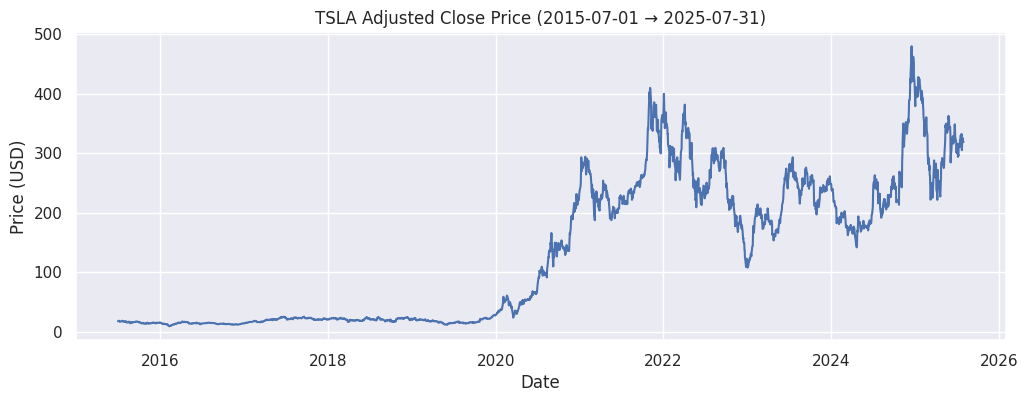

,Stats
count,2631.000000
mean,0.001744
std,0.036149
min,-0.185778
25%,-0.016503
50%,0.001185
75%,0.018893
max,0.226900


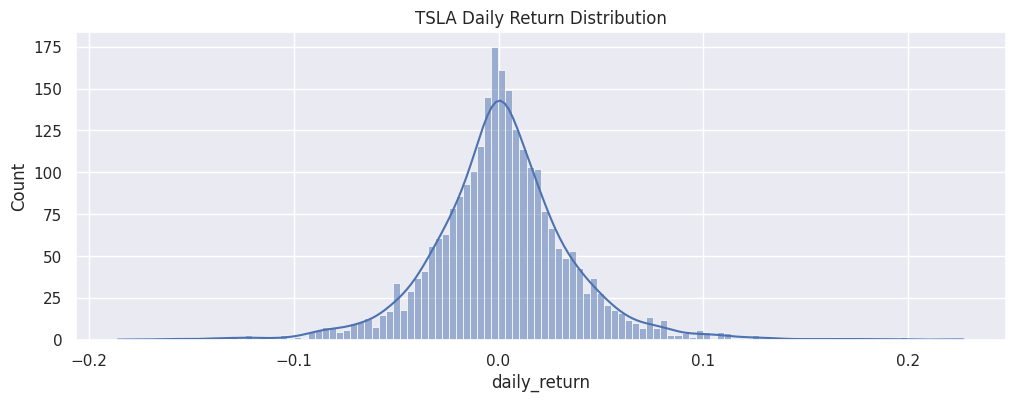

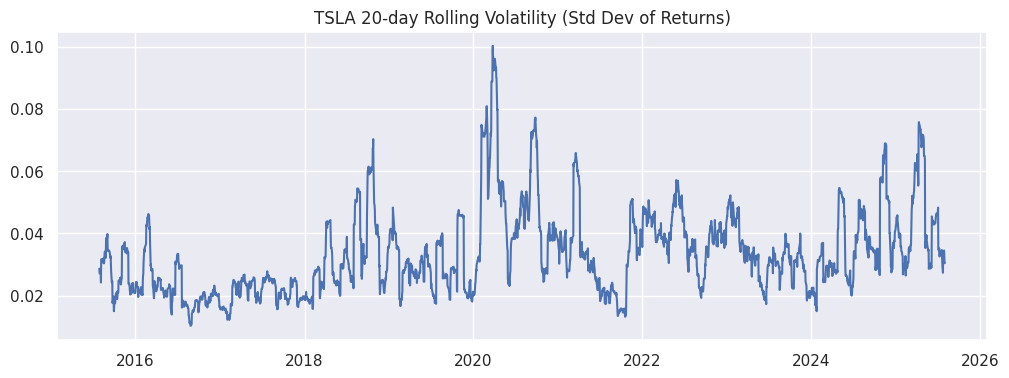

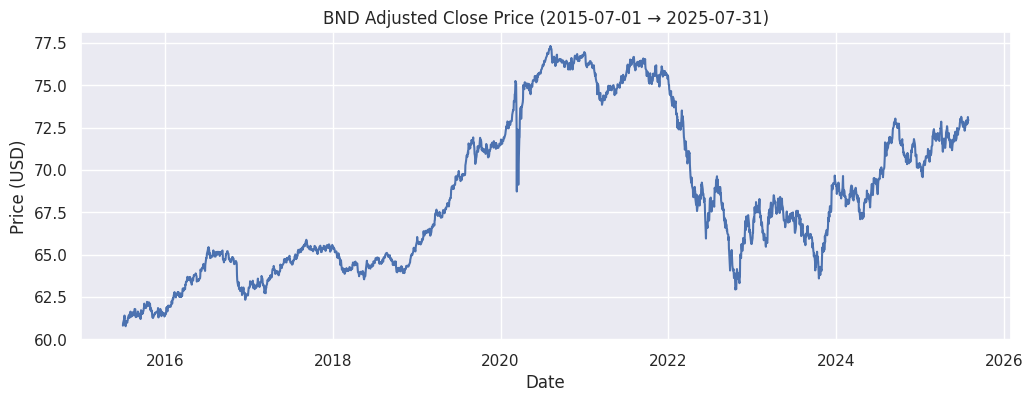

,Stats
count,2631.000000
mean,0.000075
std,0.003370
min,-0.054385
25%,-0.001465
50%,0.000125
75%,0.001706
max,0.042201


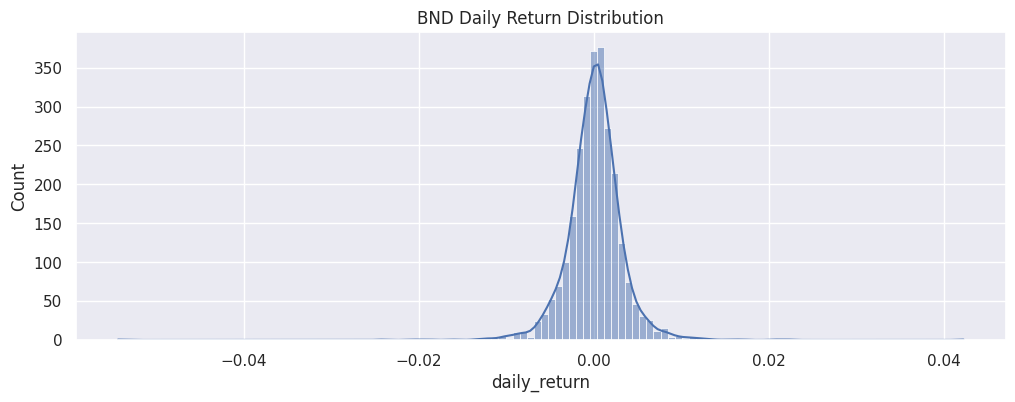

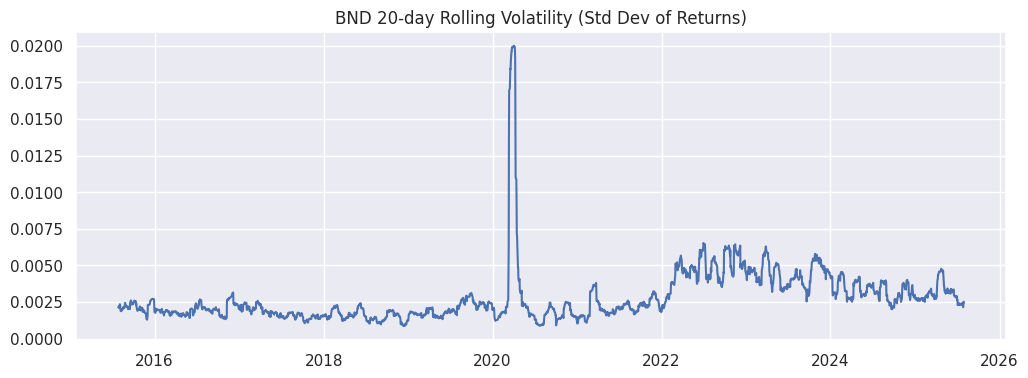

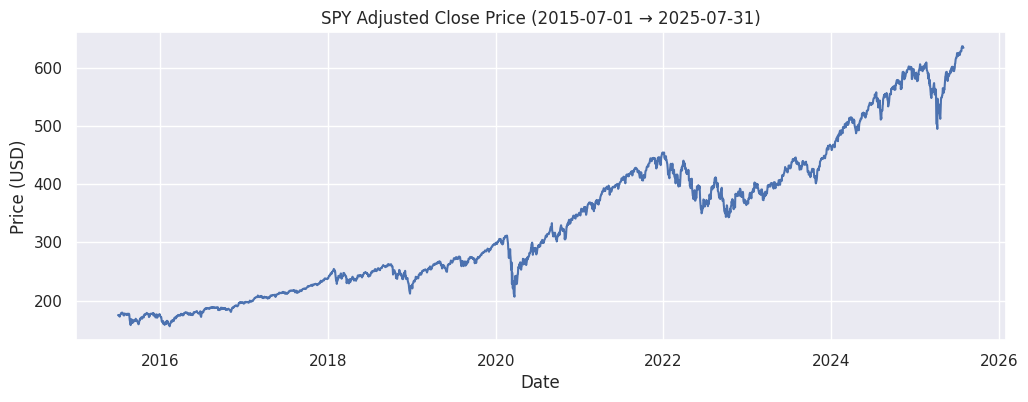

,Stats
count,2631.000000
mean,0.000553
std,0.011197
min,-0.109424
25%,-0.003428
50%,0.000531
75%,0.005710
max,0.105019


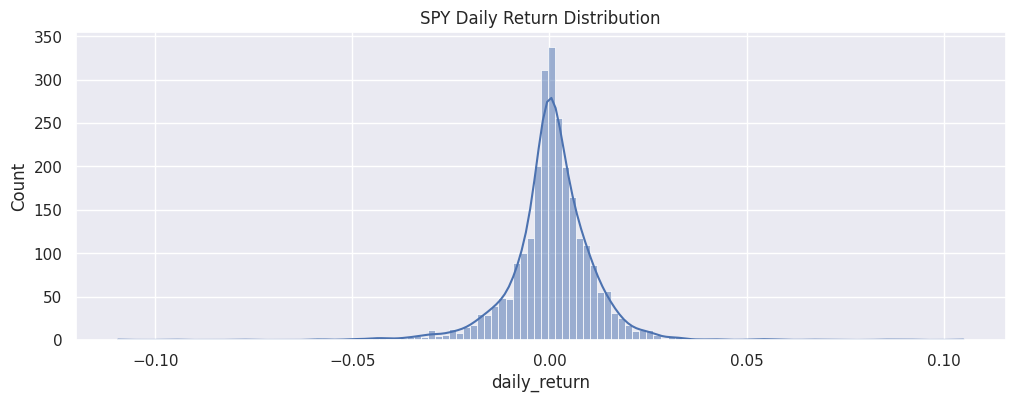

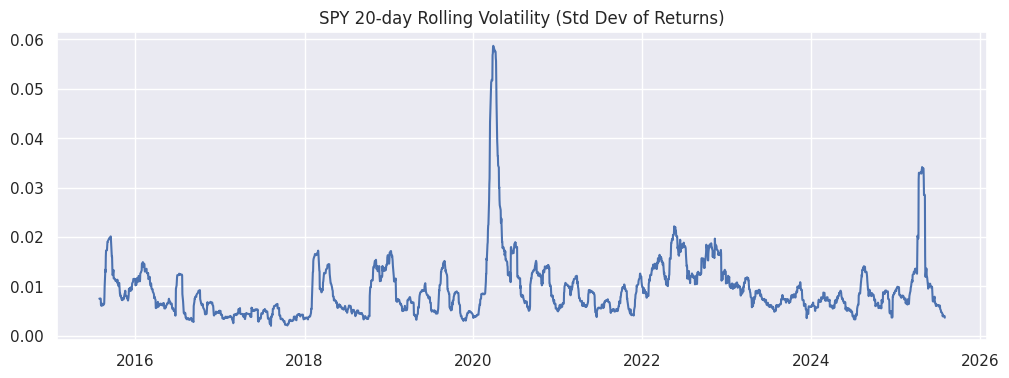

In [5]:

for t, df in cleaned.items():
    plt.figure(figsize=(12,4))
    plt.plot(df['Adj Close'])
    plt.title(f'{t} Adjusted Close Price (2015-07-01 → 2025-07-31)')
    plt.ylabel('Price (USD)')
    plt.xlabel('Date')
    plt.show()


    df['daily_return'] = df['Adj Close'].pct_change()
    display(df['daily_return'].describe().to_frame(name='Stats'))
    plt.figure(figsize=(12,4))
    sns.histplot(df['daily_return'].dropna(), bins=120, kde=True)
    plt.title(f'{t} Daily Return Distribution')
    plt.show()


    df['rolling_mean_20'] = df['daily_return'].rolling(window=20).mean()
    df['rolling_std_20'] = df['daily_return'].rolling(window=20).std()
    plt.figure(figsize=(12,4))
    plt.plot(df['rolling_std_20'])
    plt.title(f'{t} 20-day Rolling Volatility (Std Dev of Returns)')
    plt.show()

# 5) Outlier detection (Z-score & IQR) and Augmented Dickey-Fuller test

In [6]:

outliers_summary = {}

for t, df in cleaned.items():
    # compute z-score on returns
    ret = df['daily_return'].dropna()
    zscores = pd.Series(stats.zscore(ret), index=ret.index)
    df.loc[ret.index, 'zscore'] = zscores
    z_outliers = df[(df['zscore'].abs() > 3)][['Adj Close','daily_return','zscore']]

    # IQR method on returns
    q1 = ret.quantile(0.25)
    q3 = ret.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - 1.5*iqr
    upper = q3 + 1.5*iqr
    iqr_outliers = df[(df['daily_return'] < lower) | (df['daily_return'] > upper)][['Adj Close','daily_return']]

    # ADF tests
    adf_price = adfuller(df['Adj Close'].dropna(), autolag='AIC')
    adf_ret = adfuller(df['daily_return'].dropna(), autolag='AIC')

    outliers_summary[t] = {
        'z_outliers_count': len(z_outliers),
        'iqr_outliers_count': len(iqr_outliers),
        'top_z_outliers': z_outliers.sort_values('daily_return').head(10),
        'adf_price_stat': adf_price[0],
        'adf_price_pvalue': adf_price[1],
        'adf_ret_stat': adf_ret[0],
        'adf_ret_pvalue': adf_ret[1]
    }
    print(f'--- {t} ---')
    print('Z-outliers:', len(z_outliers), 'IQR-outliers:', len(iqr_outliers))
    print('ADF price p-value:', adf_price[1], ' -->', 'stationary' if adf_price[1] < 0.05 else 'non-stationary')
    print('ADF returns p-value:', adf_ret[1], ' -->', 'stationary' if adf_ret[1] < 0.05 else 'non-stationary')
    display(outliers_summary[t]['top_z_outliers'].head(10))

--- TSLA ---
Z-outliers: 40 IQR-outliers: 155
ADF price p-value: 0.5323716453435743  --> non-stationary
ADF returns p-value: 1.7362086560998894e-28  --> stationary


,Adj Close,daily_return,zscore
2020-03-16,29.671333,-0.185778,-5.188420
2020-02-05,48.980000,-0.171758,-4.800519
2020-03-18,24.081333,-0.160344,-4.484703
2020-09-07,117.412500,-0.157971,-4.419050
2025-03-10,222.149994,-0.154262,-4.316425
2025-06-05,284.700012,-0.142599,-3.993726
2018-09-28,17.651333,-0.139015,-3.894574
2019-07-25,15.254667,-0.136137,-3.814937
2020-03-09,40.533333,-0.135725,-3.803542
2019-01-18,20.150667,-0.129711,-3.637142


--- BND ---
Z-outliers: 32 IQR-outliers: 118
ADF price p-value: 0.5282052267670093  --> non-stationary
ADF returns p-value: 1.521776100914395e-18  --> stationary


,Adj Close,daily_return,zscore
2020-03-12,68.737877,-0.054385,-16.163702
2020-03-18,69.182846,-0.024140,-7.187033
2020-03-17,70.894257,-0.020685,-6.161523
2020-03-11,72.691208,-0.018940,-5.643490
2022-06-13,66.320747,-0.016153,-4.816367
2020-03-10,74.094536,-0.013444,-4.012475
2022-09-26,64.352341,-0.012777,-3.814507
2022-03-02,72.621544,-0.012284,-3.668168
2025-04-07,71.986046,-0.012056,-3.600484
2024-04-10,67.565666,-0.011686,-3.490551


--- SPY ---
Z-outliers: 38 IQR-outliers: 196
ADF price p-value: 0.9921390966434221  --> non-stationary
ADF returns p-value: 2.881235571150843e-27  --> stationary


,Adj Close,daily_return,zscore
2020-03-16,221.050415,-0.109424,-9.823642
2020-03-12,228.662979,-0.095677,-8.595735
2020-03-09,252.735626,-0.078095,-7.025193
2025-04-04,503.790649,-0.058543,-5.278728
2020-06-11,278.677094,-0.057649,-5.198877
2020-03-18,221.188629,-0.050633,-4.572160
2025-04-03,535.118042,-0.049281,-4.451391
2020-03-11,252.855438,-0.048748,-4.403827
2020-04-01,228.190567,-0.045005,-4.069423
2020-02-27,274.190979,-0.044912,-4.061109


# 6) Risk metrics: VaR (historical), Parametric VaR, and Sharpe Ratio (annualized)

In [7]:

results = {}
rf_annual = 0.03
rf_daily = rf_annual/252

for t, df in cleaned.items():
    ret = df['daily_return'].dropna()

    var_95 = ret.quantile(0.05)

    mu = ret.mean()
    sigma = ret.std()
    from scipy.stats import norm
    z_95 = norm.ppf(0.05)
    param_var_95 = mu + z_95 * sigma

    # Annualized Sharpe
    sharpe_annual = (mu - rf_daily) / sigma * np.sqrt(252)

    results[t] = {
        'daily_mean_return': mu,
        'daily_std': sigma,
        'hist_var_95': var_95,
        'param_var_95': param_var_95,
        'sharpe_annual': sharpe_annual
    }
    print(f'{t} | mean:{mu:.6f} std:{sigma:.6f} histVaR95:{var_95:.4f} sharpe_annual:{sharpe_annual:.2f}')

results_df = pd.DataFrame(results).T
display(results_df)

TSLA | mean:0.001744 std:0.036149 histVaR95:-0.0526 sharpe_annual:0.71
BND | mean:0.000075 std:0.003370 histVaR95:-0.0047 sharpe_annual:-0.21
SPY | mean:0.000553 std:0.011197 histVaR95:-0.0167 sharpe_annual:0.61


,daily_mean_return,daily_std,hist_var_95,param_var_95,sharpe_annual
TSLA,0.001744,0.036149,-0.052559,-0.057716,0.713554
BND,0.000075,0.003370,-0.004746,-0.005468,-0.208331
SPY,0.000553,0.011197,-0.016687,-0.017865,0.614797


# 7) Save cleaned datasets and a short CSV summary for interim submission

In [8]:

for t, df in cleaned.items():
    fn = f'/content/cleaned_{t}.csv'
    df.to_csv(fn)
    print('Saved', fn)

results_df.to_csv('/content/risk_metrics_summary.csv')
print('Saved /content/risk_metrics_summary.csv')


Saved /content/cleaned_TSLA.csv
Saved /content/cleaned_BND.csv
Saved /content/cleaned_SPY.csv
Saved /content/risk_metrics_summary.csv
